In this notebook I'm gonna try to obtain the performance of an "idealized" portfolio. That is, a portfolio that is always on a specific point of the Markowitz efficient frontier. This point could be, for example, the point with the highest return-risk tradeoff (sharpe ratio) or could also be the point with the highest return, etc; 

it really doesn't matter, what it is important is that everytime the efficient frontier moves, the portfolio is at a point with the same characteristics than at previous points in time.

What would it be the performance of such a portfolio? How it would behave?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

#Turn off progress printing
solvers.options['show_progress']=False

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import plotly.graph_objs as go


#This is necessary for the visualization service
import plotly
py.sign_in('linobi', 'xlupudvz62')
import cufflinks
plotly.__version__

from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo

As usual, we can choose between real or artificial data. For real data:

In [2]:
#starting and ending dates
end = pd.Timestamp(datetime(2016, 1, 1))
start = end - 2500* pd.tseries.offsets.BDay() #This is approximately ten years.

#Tickers to use. Be careful with the combination of signals and periods to be used...
#if some data is missing or has a weird behavior (including constant returns, like in the case of bonds or most fixed income)
#the quadratic optimizator will go to hell
data = load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 
                                    'MSFT', 'TLT'],
                            start=start, end=end)

return_vec = data.loc[:, :, 'price'].pct_change().dropna()

#in case you wanna take a look of the imported data:
#data.loc[:, :, 'price'].iplot(filename='prices', yTitle='price in $', world_readable=True, asDates=True)

/Users/lino/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning:

load_bars_from_yahoo is deprecated, please register a yahoo_equities data bundle instead



For artificial data:

In [ ]:
## Number of assets... we'll simulate the same amount of assets used above, just for the sake of it
n_assets = 6
## Number of observations... and the same size of sample
n_obs = 2500

return_vec = np.random.randn(n_assets, n_obs)

#Put the artificial series in dataframe form
return_vec = return_vec.T

And the Markowitz Optimization Technique:

In [3]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0*t/N - 1.0) for t in range(N)]
    
    #Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    #Create constraint matrices
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate risks and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## Calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    ## Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

First we'll get the set of efficient frontiers through time.

In [4]:
Period = []
Returns = []
Risks = []

#we'll try this trick to plot a nice surface
Returns_surfs = []

#we'll find the efficient frontier every 20 days
for x in range (0,120):
    
    returns_snapshot = return_vec[0 + x*20 : 250 + x*20].copy() #you need to do this stupid copy, because the optimizer needs the arrays transposed, and the dynamic nature of python will attempt to transpose the chopped array into the whole one.
    weights, ret, ris = optimal_portfolio(returns_snapshot.T)
    
    for y in range (0,len(ret)):
        Period.append(x)
    
    Returns_surfs.append(ret)
    
    Returns = Returns + ret 
    Risks = Risks + ris

And plotting:

In [5]:
trace1 = go.Scatter3d(
    x=Period,
    y=Risks,
    z=Returns,
    mode='markers',
    marker=dict(
        size=1,
        color=Returns,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dynamic-frontier-20days-2006-2016-AAPL-MST-GLD-TLT-XOM-IBM')

Now we gonna try to find the "trajectory" that the selected portfolio travels through time.

In order to do so, and since the optimizer only returns the weights of the portfolio (and not its performance metrics), we gonna need a function that "reverses" these weights into the spatial performance metrics in the markowitz framework.

Note that it shouldn't be that way. In an ideal world, we tell the optimizer exactly the risk we are willing to bear and it gives us in return the highest possible return for such risk, along the weights for such portfolio. But this is what it is for now.

On the other hand, notice that telling the optimizer to maximize the return given some risk may also not be entirely correct, expecially if we don't know the exact form of the efficient frontier, i.e. its current distant or offset from origin. That why it's better to ask the optimizer to find a portfolio that complies with a specific characteristic, p.e., highest return, highest sharpe ratio, minimum risk, etc.

In the cell below we define the function that receives as an input a vector of weights, and a set of vector of returns and outputs the performance metrics (return & risk) for the portfolio defined by such weights. The inputs must be in row form.

In [6]:
def portfolio_performance(returns, weights):
    '''
    Returns the mean and the standard deviation of returns for a given portfolio (given a set of time series)
    '''
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(weights)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

Ok, so now let's get the sequence of efficient portfolios using the same logic we used to get the sequence of efficient frontiers:

In [7]:
Period = []
Return_star = []
Risk_star = []

#we'll find the efficient frontier every 20 days
for x in range (0,120):
    
    returns_snapshot = return_vec[0 + x*20 : 250 + x*20].copy() #you need to do this stupid copy, because the optimizer needs the arrays transposed, and the dynamic nature of python will attempt to transpose the chopped array into the whole one.
    weights, _, _ = optimal_portfolio(returns_snapshot.T)
    ret, ris = portfolio_performance(returns_snapshot.T, weights.T) #notice the row form.
    
    Period.append(x)                   #These are coordinates x
    Risk_star.append(ris[0,0])        #These are coordinates y #porfolio_performance returns the data in matrix form, hence the need to grab it this way
    Return_star.append(ret[0,0])    #These are coordinates z

Let's plot it.

In [8]:
trace = go.Scatter3d(
    x=Period, y=Risk_star, z=Return_star,
    marker=dict(
        size=4,
        color=Return_star,
        colorscale='Viridis',
    ),
    line=dict(
        color='#1f77b4',
        width=1
    )
)

data = [trace]

fig = dict(data=data)

py.iplot(fig, filename='idea_portfolio_trace')

It looks like madness, doesn't it? In order to appreciate a bit better, we gonna plot it along the rest of the dynamic frontier, to try to make the most sense of it.

In [9]:
data = [trace, trace1]

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='idea_portfolio_dynamic_front')

Ok, but.. what would be the performance of such an "ideal" portfolio? That is, how would our money do if, somehow, we managed to always stay in that series of portfolios through time?



We propose that the performance -or behavior- of an ideal portfolio can be modelled through something called "stochastic processes". A stochastich process is basically a set of, time indexed, random variables, and it is mathematically denoted as:

$$ {X_t: t \in T} $$

There are many well known and widely studied stochastich processes -like the famous Brownian Motion- that can be modelled in a parametrized fashion.

Since we still don't know too much about the stochastich process we are dealing with here, we gonna have to generate its output by simply relying upon each of the observations we've got. That is, we are gonna say that for each instant of time $t$ our portfolio will gain (or lose) according to:

$$ Return_t = N(\mu_t , \sigma_t) $$

That is, $Return_t$ is a random variable with gaussian distribution with mean $\mu_t$ and standard dev $\sigma_t$. The geometric location of the ideal portfolio at instant $t$ directly defines the values of $\mu_t$ and $\sigma_t$ in a natural way. This return value is given in percentile terms.

So, for example, let's say I'got an initial portfolio value of $100,000:

In [10]:
Portfolio_value = [None] * 120
Portfolio_value[0] = 100000

What would it be its value at instant $t=1$?
First, let's see where is the ideal portfolio at one instant before $t=1$, because that is what will define how could increase or decrease for the next instant of time:

In [11]:
print(Return_star[0])
print(Risk_star[0])

0.00282859089463
0.0209411912773


These values can also be found in our last plot.
Now we need to simulate a the result of a random variable with a gaussian distribution and such parameters.

In [12]:
Return_ = np.random.normal(Return_star[0],Risk_star[0])
print(Return_)

-0.01990580722554728


This value changes with every run. But just for one of it, let's see how our portfolio would have done:

In [13]:
Portfolio_value[1] = Portfolio_value[0] + Portfolio_value[0] * Return_
print(Portfolio_value[1])

98009.41927744527


Well, actually this value is completely incorrect. Remember that our Return_star and Risk_star vector are for periods every twenty days. So we need to get the full star vectors for the entire time length, not a downsampled version of them. Just for the sake of it, we gonna apply the markowitz style optimization with samples of 100 days (in order to mimic the earlier simulation we did in the constant_frequency_optimization notebook.

In [14]:
Period = []
Return_star = []
Risk_star = []

#we'll find the efficient frontier every 20 days
for x in range (0,2500 - 100):
    
    returns_snapshot = return_vec[0 + x : 100 + x].copy() #you need to do this stupid copy, because the optimizer needs the arrays transposed, and the dynamic nature of python will attempt to transpose the chopped array into the whole one.
    weights, _, _ = optimal_portfolio(returns_snapshot.T)
    ret, ris = portfolio_performance(returns_snapshot.T, weights.T) #notice the row form.
    
    Period.append(x)                   #These are coordinates x
    Risk_star.append(ris[0,0])        #These are coordinates y #porfolio_performance returns the data in matrix form, hence the need to grab it this way
    Return_star.append(ret[0,0])    #These are coordinates z

Now we can apply the stochastic process to the initial portfolio and get a possible final return for the entire investment period.

In [15]:
Portfolio_value = [None] * len(Return_star) #or Risk_star whatever
Portfolio_value[0] = 100000 #and account value
for x in range (1,len(Return_star)):
    Return_ = np.random.normal(Return_star[x-1],Risk_star[x-1])
    Portfolio_value[x] = Portfolio_value[x-1] + Portfolio_value[x-1] * Return_

And the final value of such an "ideal" portfolio is:

In [16]:
Portfolio_value[-1]

17845595.370903533

Let's watch it's behavior

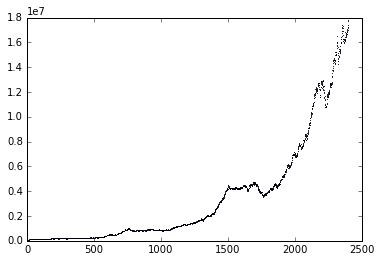

In [17]:
fig = plt.figure()
plt.plot(Portfolio_value, 'o', markersize=.5)
plt.show()